In [1]:
import pandas as pd

In [2]:
openSourceList = ['T5', 'mT5', 'CPM-2','T0','GPT-NeoX-20B','CodeGen','Tk-Instruct','UL2','OPT','NLLB','BLOOM','GLM','Flan-T5','mT0','BLOOMZ','OPT-IML','Pythia','LLaMA','Vicuna','ChatGLM','CodeGeeX','Koala','GPT-2',]
closeSourceList = ['GShard','GPT-3', 'LaMDA','HyperCLOVA','Codex','ERNIE 3','Jurassic-1','FLAN','MT-NLG','Yuan 1.0','Anthropic','WebGPT','Gopher','ERNIE 3.0 Titan','GLaM','InstructGPT','ChatGPT','AlphaCode','Chinchilla','PaLM','Cohere','AlexaTM','Sparrow','WeLM','U-PaLM','Flan-PaLM','Flan-U-PaLM','Alpaca','GPT-4','Claude']

# read the data

In [3]:
llm_data = pd.read_csv('https://raw.githubusercontent.com/jiaweixu98/ChatGPTinnovationWaves/main/llm_data_with_affiliation.csv')

In [4]:
llm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_x                      5098 non-null   float64
 1   submitter                 5098 non-null   object 
 2   authors_x                 5098 non-null   object 
 3   title                     5098 non-null   object 
 4   comments                  2732 non-null   object 
 5   journal-ref               143 non-null    object 
 6   doi                       176 non-null    object 
 7   report-no                 8 non-null      object 
 8   categories                5098 non-null   object 
 9   license                   5098 non-null   object 
 10  abstract                  5098 non-null   object 
 11  versions                  5098 non-null   object 
 12  update_date               5098 non-null   object 
 13  authors_parsed            5098 non-null   object 
 14  ContainC

In [5]:
llm_data['publish_date_v1']

0       2019-02-25
1       2019-03-05
2       2019-03-21
3       2019-03-22
4       2019-03-27
           ...    
5093    2023-09-29
5094    2023-09-29
5095    2023-09-30
5096    2023-09-30
5097    2023-09-29
Name: publish_date_v1, Length: 5098, dtype: object

In [6]:
import requests
url = 'https://raw.githubusercontent.com/jiaweixu98/ChatGPTinnovationWaves/main/model2paper.pkl'
r = requests.get(url)
with open('model2paper.pkl', 'wb') as f:
    f.write(r.content)

model2paper = pd.read_pickle('model2paper.pkl')

In [7]:
# Create a list of tuples where each tuple is (model name, number of arxivs)
model_arxiv_counts = [(model, len(arxivs)) for model, arxivs in model2paper.items()]

# Sort the list in descending order by the number of arxivs
model_arxiv_counts = sorted(model_arxiv_counts, key=lambda x: x[1], reverse=True)

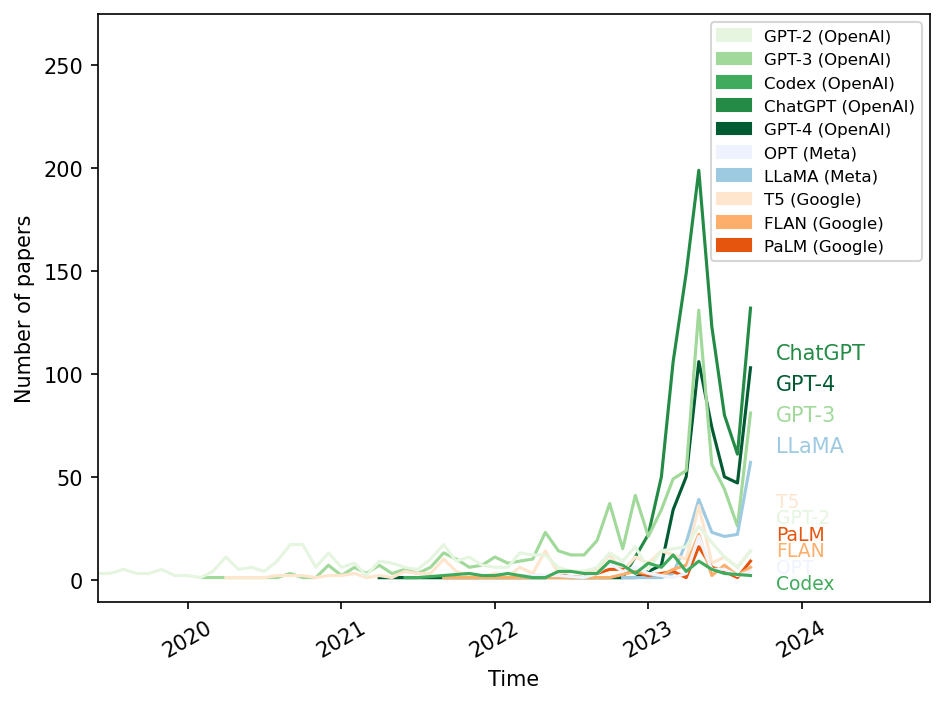

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Convert publish_date_v1 to datetime and extract month-year
llm_data['publish_date_v1'] = pd.to_datetime(llm_data['publish_date_v1'])
llm_data['month_year'] = llm_data['publish_date_v1'].dt.to_period('M')

# Create a new DataFrame where each row is an (id, model) pair
id_model_pairs = [(str(arxiv_id), model) for model, arxiv_ids in model2paper.items() for arxiv_id in arxiv_ids]
id_model_df = pd.DataFrame(id_model_pairs, columns=['id_x', 'model_name'])

# Convert 'id_x' in llm_data to string
llm_data['id_x'] = llm_data['id_x'].astype(str)

# Merge llm_data with id_model_df
merged_data = pd.merge(llm_data, id_model_df, on='id_x')

# Group by model_name and month_year, and count the number of papers
paper_counts = merged_data.groupby(['model_name', 'month_year']).size()

# Define the color groups
color_groups = {
    '#e5f5e0': ['GPT-2'],
    '#a1d99b': ['GPT-3'],
    '#41ab5d': ['Codex'],
    '#238b45': ['ChatGPT'],
    '#005a32': ['GPT-4'],
    '#eff3ff': ['OPT'],
    '#9ecae1': ['LLaMA'],
    '#fee6ce': ['T5'],
    '#fdae6b': ['FLAN'],
    '#e6550d': ['PaLM']
}

# Create a new figure with a DPI of 150
plt.figure(dpi=150)

# Calculate the rightmost value for each model
rightmost_values = {model: paper_counts.loc[model].values[-1] for color, models in color_groups.items() for model in models}

# Sort the models based on their rightmost value
sorted_models = sorted(rightmost_values.items(), key=lambda item: item[1])

# Reverse the rank of the sorted models
sorted_models = list(reversed(sorted_models))

# Calculate the y-position for each annotation
y_positions_top_4 = range(110, 50, -15)
y_positions_rest = range(38, -11, -8)

# Initialize min_x and max_x
min_x = pd.Timestamp.max
max_x = pd.Timestamp.min

# Plot the results
for i, (model, rightmost_value) in enumerate(sorted_models):
    color = [color for color, models in color_groups.items() if model in models][0]
    model_paper_counts = paper_counts.loc[model]
    # Convert Period objects to timestamps
    x = model_paper_counts.index.to_timestamp()
        # Update min_x and max_x
    min_x = min(min_x, x.min())
    max_x = max(max_x, x.max())
    plt.plot(x, model_paper_counts.values, label=model, color=color)
    # Annotate the name of each line at the right end
    if i < 4:
        plt.text(x[-1]+pd.DateOffset(months=2), y_positions_top_4[i], model, color=color, va='center')
    else:
        plt.text(x[-1]+pd.DateOffset(months=2), y_positions_rest[i-4], model, color=color, va='center', fontsize=9)

plt.xlabel('Time')
plt.ylabel('Number of papers')
plt.xticks(rotation=30)

# Adjust the x-limits to leave some space on the right
plt.xlim(min_x, max_x + pd.DateOffset(months=14))
plt.ylim(-11, 275)

# Create custom legend handles and labels
handles = [mpatches.Patch(color=color, label=model) for color, models in color_groups.items() for model in models]
labels = [f'{model} (OpenAI)' if model in color_groups['#e5f5e0'] + color_groups['#a1d99b'] + color_groups['#41ab5d'] + color_groups['#238b45'] + color_groups['#005a32'] 
          else f'{model} (Meta)' if model in color_groups['#eff3ff'] + color_groups['#9ecae1'] 
          else f'{model} (Google)' for color, models in color_groups.items() for model in models]

plt.legend(handles, labels, fontsize=8, loc='upper right')
plt.tight_layout()
plt.show()

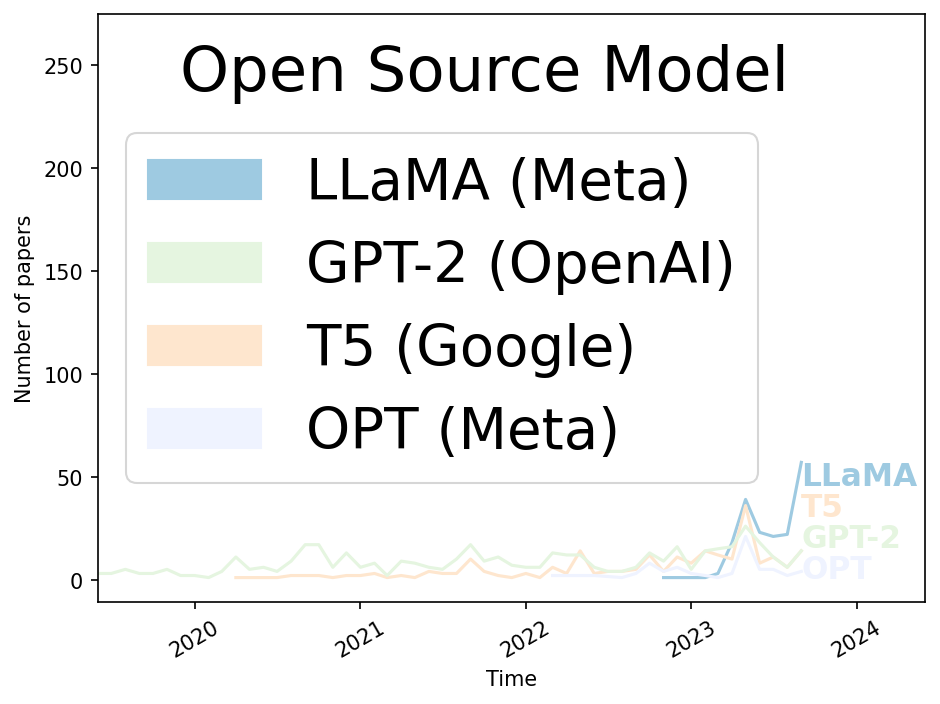

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Convert publish_date_v1 to datetime and extract month-year
llm_data['publish_date_v1'] = pd.to_datetime(llm_data['publish_date_v1'])
llm_data['month_year'] = llm_data['publish_date_v1'].dt.to_period('M')

# Create a new DataFrame where each row is an (id, model) pair
id_model_pairs = [(str(arxiv_id), model) for model, arxiv_ids in model2paper.items() for arxiv_id in arxiv_ids]
id_model_df = pd.DataFrame(id_model_pairs, columns=['id_x', 'model_name'])

# Convert 'id_x' in llm_data to string
llm_data['id_x'] = llm_data['id_x'].astype(str)

# Merge llm_data with id_model_df
merged_data = pd.merge(llm_data, id_model_df, on='id_x')

# Group by model_name and month_year, and count the number of papers
paper_counts = merged_data.groupby(['model_name', 'month_year']).size()

# Define the color groups
# color_groups = {
#     '#e5f5e0': ['GPT-2'],
#     '#a1d99b': ['GPT-3'],
#     '#41ab5d': ['Codex'],
#     '#238b45': ['ChatGPT'],
#     '#005a32': ['GPT-4'],
#     '#eff3ff': ['OPT'],
#     '#9ecae1': ['LLaMA'],
#     '#fee6ce': ['T5'],
#     '#fdae6b': ['FLAN'],
#     '#e6550d': ['PaLM']
# }
color_groups = {
    
    # '#a1d99b': ['GPT-3'],
    # '#41ab5d': ['Codex'],
    # '#238b45': ['ChatGPT'],
    # '#005a32': ['GPT-4'],
    '#9ecae1': ['LLaMA'],
        '#e5f5e0': ['GPT-2'],

    '#fee6ce': ['T5'],
    '#eff3ff': ['OPT'],
    # '#fdae6b': ['FLAN'],
    # '#e6550d': ['PaLM']
}
# Create a new figure with a DPI of 150
plt.figure(dpi=150)

# Calculate the rightmost value for each model
rightmost_values = {model: paper_counts.loc[model].values[-1] for color, models in color_groups.items() for model in models}

# Sort the models based on their rightmost value
sorted_models = sorted(rightmost_values.items(), key=lambda item: item[1])

# Reverse the rank of the sorted models
sorted_models = list(reversed(sorted_models))

# Calculate the y-position for each annotation
y_positions_top_4 = range(50, -10, -15)

# Initialize min_x and max_x
min_x = pd.Timestamp.max
max_x = pd.Timestamp.min

# Plot the results
for i, (model, rightmost_value) in enumerate(sorted_models):
    color = [color for color, models in color_groups.items() if model in models][0]
    model_paper_counts = paper_counts.loc[model]
    # Convert Period objects to timestamps
    x = model_paper_counts.index.to_timestamp()
    # Update min_x and max_x
    min_x = min(min_x, x.min())
    max_x = max(max_x, x.max())
    plt.plot(x, model_paper_counts.values, label=model, color=color)
    # Annotate the name of each line at the right end
    if i < 4:
        plt.text(x[-1]+pd.DateOffset(months=0), y_positions_top_4[i], model, color=color, va='center',fontsize=15, weight='bold')
    else:
        plt.text(x[-1]+pd.DateOffset(months=0), y_positions_rest[i-4], model, color=color, va='center', fontsize=15, weight='bold')

plt.xlabel('Time')
plt.ylabel('Number of papers')
plt.xticks(rotation=30)

# Adjust the x-limits to leave some space on the right
plt.xlim(min_x, max_x + pd.DateOffset(months=9))
plt.ylim(-11, 275)

# # Create custom legend handles and labels
# handles = [mpatches.Patch(color=color, label=model) for color, models in color_groups.items() for model in models]
# labels = [f'{model} (OpenAI)' if model in color_groups['#e5f5e0'] + color_groups['#a1d99b'] + color_groups['#41ab5d'] + color_groups['#238b45'] + color_groups['#005a32'] 
#           else f'{model} (Meta)' if model in color_groups['#eff3ff'] + color_groups['#9ecae1'] 
#           else f'{model} (Google)' for color, models in color_groups.items() for model in models]
plt.text(0.1, 0.95, 'Open Source Model', transform=plt.gca().transAxes, fontsize=30, va='top')
# Create custom legend handles and labels
handles = [mpatches.Patch(color=color, label=model) for color, models in color_groups.items() for model in models]
labels = [f'{model} (OpenAI)' if model in color_groups['#e5f5e0']
          else f'{model} (Meta)' if model in color_groups['#eff3ff'] + color_groups['#9ecae1'] 
          else f'{model} (Google)' for color, models in color_groups.items() for model in models]
# Hide x-labels, x-ticks, y-labels, y-ticks, and legends
plt.legend(handles, labels, fontsize=27, loc='center left')
plt.tight_layout()
plt.show()

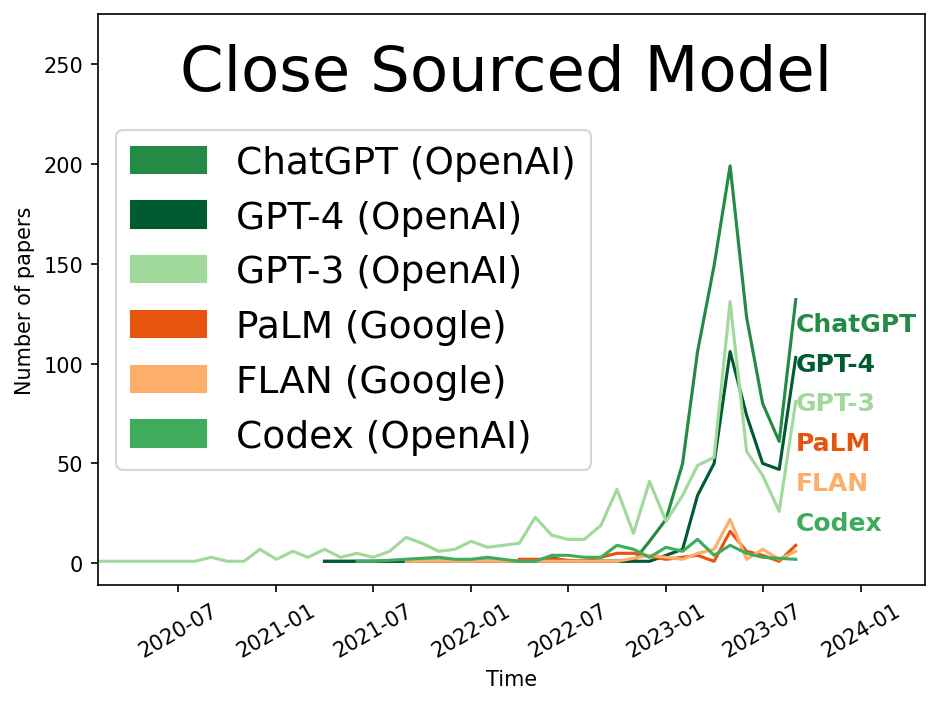

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Convert publish_date_v1 to datetime and extract month-year
llm_data['publish_date_v1'] = pd.to_datetime(llm_data['publish_date_v1'])
llm_data['month_year'] = llm_data['publish_date_v1'].dt.to_period('M')

# Create a new DataFrame where each row is an (id, model) pair
id_model_pairs = [(str(arxiv_id), model) for model, arxiv_ids in model2paper.items() for arxiv_id in arxiv_ids]
id_model_df = pd.DataFrame(id_model_pairs, columns=['id_x', 'model_name'])

# Convert 'id_x' in llm_data to string
llm_data['id_x'] = llm_data['id_x'].astype(str)

# Merge llm_data with id_model_df
merged_data = pd.merge(llm_data, id_model_df, on='id_x')

# Group by model_name and month_year, and count the number of papers
paper_counts = merged_data.groupby(['model_name', 'month_year']).size()

# Define the color groups
# color_groups = {
#     '#e5f5e0': ['GPT-2'],
#     '#a1d99b': ['GPT-3'],
#     '#41ab5d': ['Codex'],
#     '#238b45': ['ChatGPT'],
#     '#005a32': ['GPT-4'],
#     '#eff3ff': ['OPT'],
#     '#9ecae1': ['LLaMA'],
#     '#fee6ce': ['T5'],
#     '#fdae6b': ['FLAN'],
#     '#e6550d': ['PaLM']
# }
color_groups = {
        '#238b45': ['ChatGPT'],
    '#005a32': ['GPT-4'],
    '#a1d99b': ['GPT-3'],

    '#e6550d': ['PaLM'],
    '#fdae6b': ['FLAN'],
    '#41ab5d': ['Codex'],
}
# Create a new figure with a DPI of 150
plt.figure(dpi=150)

min_x = pd.Timestamp.max
max_x = pd.Timestamp.min

# Calculate the rightmost value for each model
rightmost_values = {model: paper_counts.loc[model].values[-1] for color, models in color_groups.items() for model in models}

# Sort the models based on their rightmost value
sorted_models = sorted(rightmost_values.items(), key=lambda item: item[1])

# Reverse the rank of the sorted models
sorted_models = list(reversed(sorted_models))

# Calculate the y-position for each annotation
y_positions_top_4 = range(120, -10, -20)

# Plot the results
for i, (model, rightmost_value) in enumerate(sorted_models):
    color = [color for color, models in color_groups.items() if model in models][0]
    model_paper_counts = paper_counts.loc[model]
    # Convert Period objects to timestamps
    x = model_paper_counts.index.to_timestamp()
    min_x = min(min_x, x.min())
    max_x = max(max_x, x.max())
    plt.plot(x, model_paper_counts.values, label=model, color=color)
    # Annotate the name of each line at the right end
    if i < 6:
        plt.text(x[-1]+pd.DateOffset(months=0), y_positions_top_4[i], model, color=color, va='center',fontsize=12, weight='bold')
    else:
        plt.text(x[-1]+pd.DateOffset(months=0), y_positions_rest[i-4], model, color=color, va='center', fontsize=15, weight='bold')

plt.xlabel('Time')
plt.ylabel('Number of papers')
plt.xticks(rotation=30)

# Adjust the x-limits to leave some space on the right
plt.xlim(min_x, max_x + pd.DateOffset(months=8))
plt.ylim(-11, 275)

# Create custom legend handles and labels
handles = [mpatches.Patch(color=color, label=model) for color, models in color_groups.items() for model in models]
labels = [f'{model} (OpenAI)' if model in color_groups['#a1d99b'] + color_groups['#41ab5d'] + color_groups['#238b45'] + color_groups['#005a32'] 
          else f'{model} (Google)' for color, models in color_groups.items() for model in models]
plt.text(0.1, 0.95, 'Close Sourced Model', transform=plt.gca().transAxes, fontsize=30, va='top')

plt.legend(handles, labels, fontsize=18, loc='center left')
plt.tight_layout()
plt.show()

In [11]:
model2paper.keys()

dict_keys(['T5', 'mT5', 'CPM-2', 'T0', 'GPT-NeoX-20B', 'CodeGen', 'Tk-Instruct', 'UL2', 'OPT', 'NLLB', 'BLOOM', 'GLM', 'Flan-T5', 'mT0', 'BLOOMZ', 'OPT-IML', 'Pythia', 'LLaMA', 'Vicuna', 'ChatGLM', 'CodeGeeX', 'Koala', 'GPT-2', 'GShard', 'GPT-3', 'LaMDA', 'HyperCLOVA', 'Codex', 'ERNIE 3', 'Jurassic-1', 'FLAN', 'MT-NLG', 'Yuan 1.0', 'Anthropic', 'WebGPT', 'Gopher', 'ERNIE 3.0 Titan', 'GLaM', 'InstructGPT', 'ChatGPT', 'AlphaCode', 'Chinchilla', 'PaLM', 'Cohere', 'AlexaTM', 'Sparrow', 'WeLM', 'U-PaLM', 'Flan-PaLM', 'Flan-U-PaLM', 'Alpaca', 'GPT-4', 'Claude'])

In [12]:
llm_data['categories']

0               cs.AI cs.LG cs.MA
1       cs.RO cs.AI cs.LG stat.ML
2                           cs.CL
3                   cs.LG stat.ML
4                           cs.CL
                  ...            
5093                  cs.CL cs.AI
5094            cs.CL cs.AI cs.LG
5095                  cs.LG cs.AI
5096                  cs.CL cs.AI
5097                  cs.LG cs.AI
Name: categories, Length: 5098, dtype: object

In [13]:
major_categories_dict = {id: set(category.split('.')[0] for category in categories.split(' ')) for id, categories in llm_data['categories'].items()}

# major group

In [14]:
from collections import Counter

# Initialize a Counter object
category_counts = Counter()

# Iterate over the sets of categories in the dictionary
for categories in major_categories_dict.values():
    # Update the counts
    category_counts.update(categories)

# Print the counts
for category, count in category_counts.items():
    print(f'{category}: {count}')

cs: 5043
stat: 112
eess: 133
math: 38
q-bio: 53
q-fin: 44
econ: 24
physics: 53
quant-ph: 11
cond-mat: 18
hep-th: 2
astro-ph: 8
gr-qc: 1
nlin: 4
hep-ph: 1
hep-lat: 1


# affiliation

In [15]:
import ast
import pandas as pd

# Convert the strings in the 'Institute' column back to lists
llm_data['Institute'] = llm_data['Institute'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else pd.NA)
llm_data['Institute'] = llm_data['Institute'].apply(lambda institutes: [institute for institute in institutes if institute not in ['Equal contribution', 'Equal Contribution']] if isinstance(institutes, list) else institutes)

In [16]:
llm_data['Institute']

0                    [Summit Sierra High School, Seattle]
1                                                    <NA>
2       [University of Washington, Massachusetts Insti...
3                                 [University of Toronto]
4       [Lingua Custodia 1, Place Charles de Gaulle 78...
                              ...                        
5093    [Harbin Institute of Technology, Hong Kong Uni...
5094                    [Instituto Politécnico de Leiria]
5095    [Guangzhou University, Zhejiang Lab, Zhejiang ...
5096            [University of California, Santa Barbara]
5097    [Eindhoven University of Technology, The Unive...
Name: Institute, Length: 5098, dtype: object

In [17]:
llm_data['Country'] = llm_data['Country'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else pd.NA)

In [18]:
# Create a new DataFrame where the 'Institute' column is not NaN
llm_data_institute = llm_data[llm_data['Institute'].notna()]
# Create a new DataFrame where the 'Country' column is not NaN
llm_data_country = llm_data[llm_data['Country'].notna()]

In [19]:
llm_data_country

,id_x,submitter,authors_x,title,comments,journal-ref,doi,report-no,categories,license,...,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,authors_y,Institute,Country,month_year
2,1903.08855,Nelson F. Liu,Nelson F. Liu and Matt Gardner and Yonatan Bel...,Linguistic Knowledge and Transferability of Co...,"22 pages, 4 figures; to appear at NAACL 2019",NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,83.0,606.0,157.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '22243769', 'name': 'Nelson F. L...","[University of Washington, Massachusetts Insti...",[United States],2019-03
3,1903.09295,'Stephen' Zhen Gou,"Stephen Zhen Gou, Yuyang Liu",DQN with model-based exploration: efficient le...,NaN,NaN,NaN,NaN,cs.LG stat.ML,http://arxiv.org/licenses/nonexclusive-distrib...,...,11.0,7.0,2.0,False,"['Computer Science', 'Mathematics']","[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '117387024', 'name': 'Stephen Go...",[University of Toronto],[Canada],2019-03
4,1903.11437,Franck Burlot,Franck Burlot and Fran\c{c}ois Yvon,Using Monolingual Data in Neural Machine Trans...,Published in the Proceedings of the Third Conf...,NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,40.0,85.0,8.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '3456893', 'name': 'Franck Burlo...","[Lingua Custodia 1, Place Charles de Gaulle 78...",[France],2019-03
5,1904.05152,Alessandro Seganti,"Alessandro Seganti, Helena Sobol, Iryna Orlova...",NLPR@SRPOL at SemEval-2019 Task 6 and Task 5: ...,NaN,NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,39.0,18.0,1.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '46539208', 'name': 'Alessandro ...",[Samsung],"[South Korea, Poland]",2019-04
6,1904.06312,Kaleigh Clary,"Kaleigh Clary, Emma Tosch, John Foley, and Dav...",Let's Play Again: Variability of Deep Reinforc...,NeurIPS 2018 Critiquing and Correcting Trends ...,NaN,NaN,NaN,cs.LG cs.AI stat.ML,http://arxiv.org/licenses/nonexclusive-distrib...,...,10.0,16.0,0.0,False,"['Mathematics', 'Computer Science']","[{'category': 'Mathematics', 'source': 'extern...","[{'authorId': '52226829', 'name': 'Kaleigh Cla...","[University of Massachusetts Amherst, Smith Co...",[United States],2019-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093,2310.01432,Zongjie Li,"Zongjie Li, Chaozheng Wang, Pingchuan Ma, Daoy...",Split and Merge: Aligning Position Biases in L...,NaN,NaN,NaN,NaN,cs.CL cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,41.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2118207559', 'name': 'Zongjie L...","[Harbin Institute of Technology, Hong Kong Uni...","[China, Singapore]",2023-09
5094,2310.01434,Tom\'as Marques,"Samuel Carreira, Tom\'as Marques, Jos\'e Ribei...",Revolutionizing Mobile Interaction: Enabling a...,NaN,NaN,NaN,NaN,cs.CL cs.AI cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,...,13.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2253468900', 'name': 'Samuel Ca...",[Instituto Politécnico de Leiria],[Portugal],2023-09
5095,2310.01436,Yang Gao,"Haishuai Wang, Yang Gao, Xin Zheng, Peng Zhang...",Graph Neural Architecture Search with GPT-4,NaN,NaN,NaN,NaN,cs.LG cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,29.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2238917689', 'name': 'Haishuai ...","[Guangzhou University, Zhejiang Lab, Zhejiang ...",[China],2023-09
5096,2310.01441,Hejia Geng,"Hejia Geng, Boxun Xu, Peng Li",UPAR: A Kantian-Inspired Prompting Framework f...,NaN,NaN,NaN,NaN,cs.CL cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,87.0,0.0,0.0,

In [20]:
llm_data_institute

,id_x,submitter,authors_x,title,comments,journal-ref,doi,report-no,categories,license,...,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,authors_y,Institute,Country,month_year
0,1902.09097,Joe Booth,"Joe Booth, Jackson Booth",Marathon Environments: Multi-Agent Continuous ...,AAAI-2019 Workshop on Games and Simulations fo...,AAAI-2019 Workshop on Games and Simulations fo...,NaN,NaN,cs.AI cs.LG cs.MA,http://arxiv.org/licenses/nonexclusive-distrib...,...,12.0,5.0,0.0,False,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '37373648', 'name': 'J. Booth'},...","[Summit Sierra High School, Seattle]",<NA>,2019-02
2,1903.08855,Nelson F. Liu,Nelson F. Liu and Matt Gardner and Yonatan Bel...,Linguistic Knowledge and Transferability of Co...,"22 pages, 4 figures; to appear at NAACL 2019",NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,83.0,606.0,157.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '22243769', 'name': 'Nelson F. L...","[University of Washington, Massachusetts Insti...",[United States],2019-03
3,1903.09295,'Stephen' Zhen Gou,"Stephen Zhen Gou, Yuyang Liu",DQN with model-based exploration: efficient le...,NaN,NaN,NaN,NaN,cs.LG stat.ML,http://arxiv.org/licenses/nonexclusive-distrib...,...,11.0,7.0,2.0,False,"['Computer Science', 'Mathematics']","[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '117387024', 'name': 'Stephen Go...",[University of Toronto],[Canada],2019-03
4,1903.11437,Franck Burlot,Franck Burlot and Fran\c{c}ois Yvon,Using Monolingual Data in Neural Machine Trans...,Published in the Proceedings of the Third Conf...,NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,40.0,85.0,8.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '3456893', 'name': 'Franck Burlo...","[Lingua Custodia 1, Place Charles de Gaulle 78...",[France],2019-03
5,1904.05152,Alessandro Seganti,"Alessandro Seganti, Helena Sobol, Iryna Orlova...",NLPR@SRPOL at SemEval-2019 Task 6 and Task 5: ...,NaN,NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,39.0,18.0,1.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '46539208', 'name': 'Alessandro ...",[Samsung],"[South Korea, Poland]",2019-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093,2310.01432,Zongjie Li,"Zongjie Li, Chaozheng Wang, Pingchuan Ma, Daoy...",Split and Merge: Aligning Position Biases in L...,NaN,NaN,NaN,NaN,cs.CL cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,41.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2118207559', 'name': 'Zongjie L...","[Harbin Institute of Technology, Hong Kong Uni...","[China, Singapore]",2023-09
5094,2310.01434,Tom\'as Marques,"Samuel Carreira, Tom\'as Marques, Jos\'e Ribei...",Revolutionizing Mobile Interaction: Enabling a...,NaN,NaN,NaN,NaN,cs.CL cs.AI cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,...,13.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2253468900', 'name': 'Samuel Ca...",[Instituto Politécnico de Leiria],[Portugal],2023-09
5095,2310.01436,Yang Gao,"Haishuai Wang, Yang Gao, Xin Zheng, Peng Zhang...",Graph Neural Architecture Search with GPT-4,NaN,NaN,NaN,NaN,cs.LG cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,29.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2238917689', 'name': 'Haishuai ...","[Guangzhou University, Zhejiang Lab, Zhejiang ...",[China],2023-09
5096,2310.01441,Hejia Geng,"Hejia Geng, Boxun Xu, Peng Li",UPAR: A Kantian-Inspired Prompting Framework f...,NaN,NaN,NaN,NaN,cs.CL cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,87.0,0.0,0.0,True,['Computer Science'],"

In [21]:
llm_data_country

,id_x,submitter,authors_x,title,comments,journal-ref,doi,report-no,categories,license,...,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,authors_y,Institute,Country,month_year
2,1903.08855,Nelson F. Liu,Nelson F. Liu and Matt Gardner and Yonatan Bel...,Linguistic Knowledge and Transferability of Co...,"22 pages, 4 figures; to appear at NAACL 2019",NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,83.0,606.0,157.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '22243769', 'name': 'Nelson F. L...","[University of Washington, Massachusetts Insti...",[United States],2019-03
3,1903.09295,'Stephen' Zhen Gou,"Stephen Zhen Gou, Yuyang Liu",DQN with model-based exploration: efficient le...,NaN,NaN,NaN,NaN,cs.LG stat.ML,http://arxiv.org/licenses/nonexclusive-distrib...,...,11.0,7.0,2.0,False,"['Computer Science', 'Mathematics']","[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '117387024', 'name': 'Stephen Go...",[University of Toronto],[Canada],2019-03
4,1903.11437,Franck Burlot,Franck Burlot and Fran\c{c}ois Yvon,Using Monolingual Data in Neural Machine Trans...,Published in the Proceedings of the Third Conf...,NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,40.0,85.0,8.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '3456893', 'name': 'Franck Burlo...","[Lingua Custodia 1, Place Charles de Gaulle 78...",[France],2019-03
5,1904.05152,Alessandro Seganti,"Alessandro Seganti, Helena Sobol, Iryna Orlova...",NLPR@SRPOL at SemEval-2019 Task 6 and Task 5: ...,NaN,NaN,NaN,NaN,cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,...,39.0,18.0,1.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '46539208', 'name': 'Alessandro ...",[Samsung],"[South Korea, Poland]",2019-04
6,1904.06312,Kaleigh Clary,"Kaleigh Clary, Emma Tosch, John Foley, and Dav...",Let's Play Again: Variability of Deep Reinforc...,NeurIPS 2018 Critiquing and Correcting Trends ...,NaN,NaN,NaN,cs.LG cs.AI stat.ML,http://arxiv.org/licenses/nonexclusive-distrib...,...,10.0,16.0,0.0,False,"['Mathematics', 'Computer Science']","[{'category': 'Mathematics', 'source': 'extern...","[{'authorId': '52226829', 'name': 'Kaleigh Cla...","[University of Massachusetts Amherst, Smith Co...",[United States],2019-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093,2310.01432,Zongjie Li,"Zongjie Li, Chaozheng Wang, Pingchuan Ma, Daoy...",Split and Merge: Aligning Position Biases in L...,NaN,NaN,NaN,NaN,cs.CL cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,41.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2118207559', 'name': 'Zongjie L...","[Harbin Institute of Technology, Hong Kong Uni...","[China, Singapore]",2023-09
5094,2310.01434,Tom\'as Marques,"Samuel Carreira, Tom\'as Marques, Jos\'e Ribei...",Revolutionizing Mobile Interaction: Enabling a...,NaN,NaN,NaN,NaN,cs.CL cs.AI cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,...,13.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2253468900', 'name': 'Samuel Ca...",[Instituto Politécnico de Leiria],[Portugal],2023-09
5095,2310.01436,Yang Gao,"Haishuai Wang, Yang Gao, Xin Zheng, Peng Zhang...",Graph Neural Architecture Search with GPT-4,NaN,NaN,NaN,NaN,cs.LG cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,29.0,0.0,0.0,True,['Computer Science'],"[{'category': 'Computer Science', 'source': 'e...","[{'authorId': '2238917689', 'name': 'Haishuai ...","[Guangzhou University, Zhejiang Lab, Zhejiang ...",[China],2023-09
5096,2310.01441,Hejia Geng,"Hejia Geng, Boxun Xu, Peng Li",UPAR: A Kantian-Inspired Prompting Framework f...,NaN,NaN,NaN,NaN,cs.CL cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,...,87.0,0.0,0.0,

In [22]:
# Count the number of publications for each institute
publication_counts = llm_data_institute['Institute'].explode().value_counts()

# Print the counts
publication_counts

Microsoft                                     250
Stanford University                           171
Carnegie Mellon University                    152
Tsinghua University                           151
Google                                        124
                                             ... 
Pusan National University Yangsan Hospital      1
University of North Dakota                      1
Bloomberg (United States)                       1
Europa-Universität Flensburg                    1
Instituto Politécnico de Leiria                 1
Name: Institute, Length: 2284, dtype: int64

In [23]:
def label_institutes(institutes):
    # List of keywords that indicate an institute is a university
    university_keywords = ['university', 'college', 'institute of technology', 'school of', 'academy', 'faculty', 'universidad', 'universite', 'universität',  'polytechnic', 'universitas', 'school', 'hospital','université', 'advanced institute of science', 'polytechnique','institute of computing technology']
    
    # Label each institute as 'university' or 'industrial'
    return ['university' if any(keyword in institute.lower() for keyword in university_keywords) else 'industrial' for institute in institutes]

# Apply the function to the 'Institute' column
llm_data_institute['Institute Type'] = llm_data_institute['Institute'].apply(label_institutes)

C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1392573761.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llm_data_institute['Institute Type'] = llm_data_institute['Institute'].apply(label_institutes)


<Figure size 960x720 with 0 Axes>

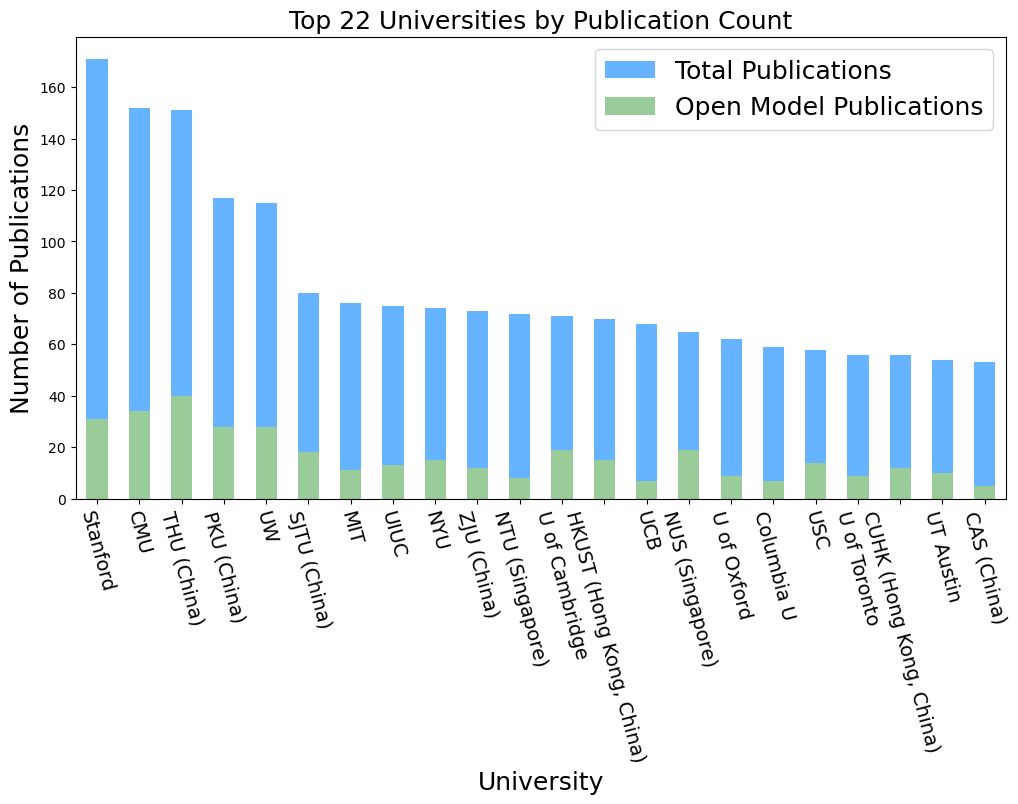

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def process_data(df, name_mapping):
    # Create a DataFrame where each row represents an institute and its type
    institutes_df = pd.DataFrame({
        'Institute': [institute for institutes in df['Institute'] for institute in institutes],
        'Institute Type': [type for types in df['Institute Type'] for type in types]
    })

    # Filter the DataFrame to include only rows where the 'Institute Type' is 'university'
    university_data = institutes_df[institutes_df['Institute Type'] == 'university']

    # Count the number of publications for each university
    university_counts = university_data['Institute'].value_counts()

    # Replace the names in the index
    university_counts.index = university_counts.index.to_series().replace(name_mapping)

    # Replace 'University' with 'U' in the remaining names
    university_counts.index = university_counts.index.str.replace('University', 'U')

    return university_counts

name_mapping = {
    'Stanford University': 'Stanford',
    'Carnegie Mellon University': 'CMU',
    'Tsinghua University': 'THU (China)',
    'Peking University': 'PKU (China)',
    'Shanghai Jiao Tong University': 'SJTU (China)',
    'Massachusetts Institute of Technology': 'MIT',
    'University of Illinois Urbana-Champaign': 'UIUC',
    'New York University': 'NYU',
    'Zhejiang University': 'ZJU (China)',
    'Nanyang Technological University': 'NTU (Singapore)',
    'Hong Kong University of Science and Technology': 'HKUST (Hong Kong, China)',
    'University of California, Berkeley': 'UCB',
    'National University of Singapore': 'NUS (Singapore)',
    'Chinese University of Hong Kong': 'CUHK (Hong Kong, China)',
    'The University of Texas at Austin': 'UT Austin',
    'Chinese Academy of Sciences': 'CAS (China)',
    'University of Washington': 'UW',
    'University of Southern California': 'USC',
}

# Process the data
top_universities = process_data(llm_data_institute, name_mapping)
open_model_data = llm_data_institute[llm_data_institute['OpenModelNumber'] != 0]
open_model_counts = process_data(open_model_data, name_mapping)

# Keep only the common indices
common_indices = open_model_counts.index.intersection(top_universities.index)
open_model_counts = open_model_counts.loc[common_indices]
top_universities = top_universities.loc[common_indices]

# Convert to DataFrame and reset index
top_universities_df = top_universities.reset_index().rename(columns={'index': 'Institute', 'Institute': 'Total Publications'})
open_model_counts_df = open_model_counts.reset_index().rename(columns={'index': 'Institute', 'Institute': 'Open Model Publications'})

# Merge the two dataframes
merged_df = pd.merge(top_universities_df, open_model_counts_df, on='Institute', how='outer')

# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

# Sort by 'Total Publications'
merged_df.sort_values(by='Total Publications', ascending=False, inplace=True)

# Reset index after sorting
merged_df.reset_index(drop=True, inplace=True)

# Select the top 22 universities
top_22_universities = merged_df.head(22)

# Set the DPI
plt.figure(dpi=150)

# Now you can plot using top_22_universities
ax = top_22_universities.plot(x='Institute', y='Total Publications', kind='bar', figsize=(12, 6), color='#66B3FF', label='Total Publications')
top_22_universities.plot(x='Institute', y='Open Model Publications', kind='bar', color='#99CC99', ax=ax, label='Open Model Publications')

# Set the title and labels
plt.title('Top 22 Universities by Publication Count',fontsize=18)
plt.xlabel('University',fontsize=18)
plt.ylabel('Number of Publications',fontsize=18)

# rotation
plt.xticks(rotation=-75)
plt.tick_params(axis='x', labelsize=14)
# Add a legend
plt.legend(fontsize=18)

# Show the plot
plt.show()

<Figure size 960x720 with 0 Axes>

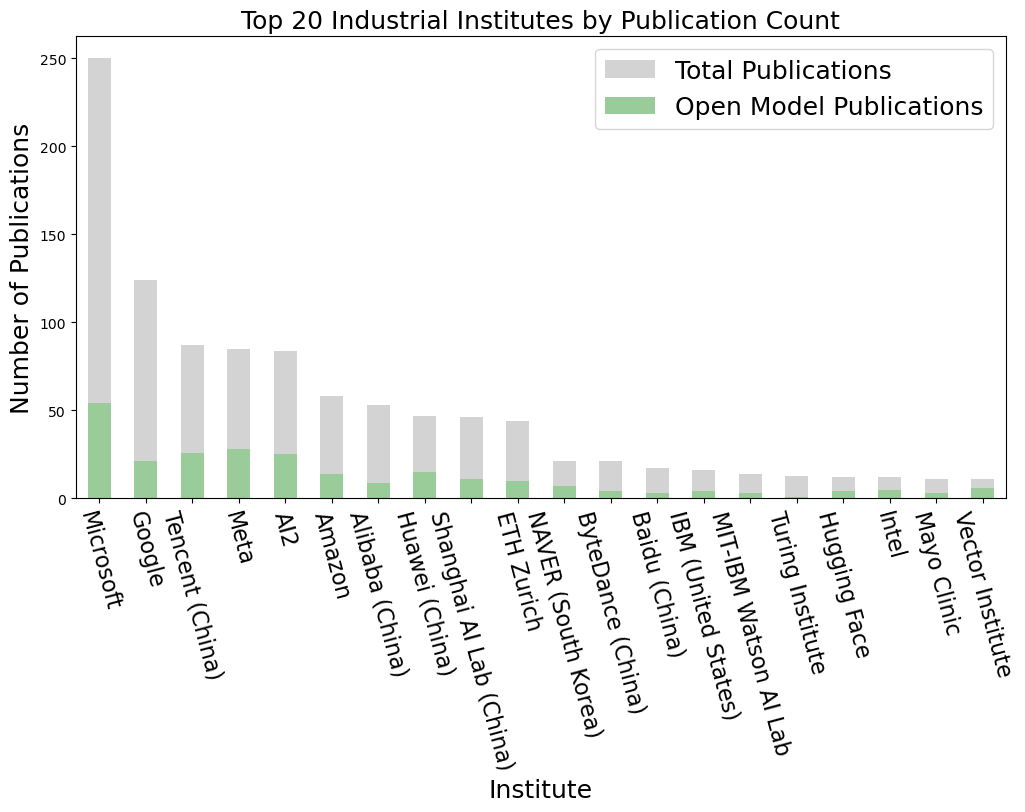

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def process_data(df, name_mapping, institute_type):
    # Create a DataFrame where each row represents an institute and its type
    institutes_df = pd.DataFrame({
        'Institute': [institute for institutes in df['Institute'] for institute in institutes],
        'Institute Type': [type for types in df['Institute Type'] for type in types]
    })

    # Filter the DataFrame to include only rows where the 'Institute Type' is 'industrial'
    institute_data = institutes_df[institutes_df['Institute Type'] == institute_type]

    # Count the number of publications for each institute
    institute_counts = institute_data['Institute'].value_counts()

    # Replace the names in the index
    institute_counts.index = institute_counts.index.to_series().replace(name_mapping)

    # Replace 'University' with 'U' in the remaining names
    institute_counts.index = institute_counts.index.str.replace('University', 'U')

    return institute_counts

name_mapping = {
 'Tencent': 'Tencent (China)',
 'Allen Institute for Artificial Intelligence': 'AI2',
 'Alibaba': 'Alibaba (China)',
 'Huawei Technologies (China)': 'Huawei (China)',
 'Shanghai Artificial Intelligence Laboratory': 'Shanghai AI Lab (China)',
 'NAVER': 'NAVER (South Korea)',
 'ByteDance': 'ByteDance (China)',
 'Baidu': 'Baidu (China)',
 'The Alan Turing Institute': 'Turing Institute',
}

# Process the data
top_institutes = process_data(llm_data_institute, name_mapping, 'industrial')
open_model_data = llm_data_institute[llm_data_institute['OpenModelNumber'] != 0]
open_model_counts = process_data(open_model_data, name_mapping, 'industrial')

# Keep only the common indices
common_indices = open_model_counts.index.intersection(top_institutes.index)
open_model_counts = open_model_counts.loc[common_indices]
top_institutes = top_institutes.loc[common_indices]

# Convert to DataFrame and reset index
top_institutes_df = top_institutes.reset_index().rename(columns={'index': 'Institute', 'Institute': 'Total Publications'})
open_model_counts_df = open_model_counts.reset_index().rename(columns={'index': 'Institute', 'Institute': 'Open Model Publications'})

# Merge the two dataframes
merged_df = pd.merge(top_institutes_df, open_model_counts_df, on='Institute', how='outer')

# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

# Sort by 'Total Publications'
merged_df.sort_values(by='Total Publications', ascending=False, inplace=True)

# Reset index after sorting
merged_df.reset_index(drop=True, inplace=True)

# Select the top 22 institutes
top_22_institutes = merged_df.head(20)

# Set the DPI
plt.figure(dpi=150)

# Now you can plot using top_22_institutes
ax = top_22_institutes.plot(x='Institute', y='Total Publications', kind='bar', figsize=(12, 6), color='lightgray', label='Total Publications')
top_22_institutes.plot(x='Institute', y='Open Model Publications', kind='bar', color='#99CC99', ax=ax, label='Open Model Publications')

# Set the title and labels
plt.title('Top 20 Industrial Institutes by Publication Count',fontsize=18)
plt.xlabel('Institute',fontsize=18)
plt.ylabel('Number of Publications',fontsize=18)

# rotation
plt.xticks(rotation=-75)
plt.tick_params(axis='x', labelsize=16)
# Add a legend
plt.legend(fontsize=18)

# Show the plot
plt.show()

In [26]:
list(top_22_institutes['Institute'])

['Microsoft',
 'Google',
 'Tencent (China)',
 'Meta',
 'AI2',
 'Amazon',
 'Alibaba (China)',
 'Huawei (China)',
 'Shanghai AI Lab (China)',
 'ETH Zurich',
 'NAVER (South Korea)',
 'ByteDance (China)',
 'Baidu (China)',
 'IBM (United States)',
 'MIT-IBM Watson AI Lab',
 'Turing Institute',
 'Hugging Face',
 'Intel',
 'Mayo Clinic',
 'Vector Institute']

<Figure size 960x720 with 0 Axes>

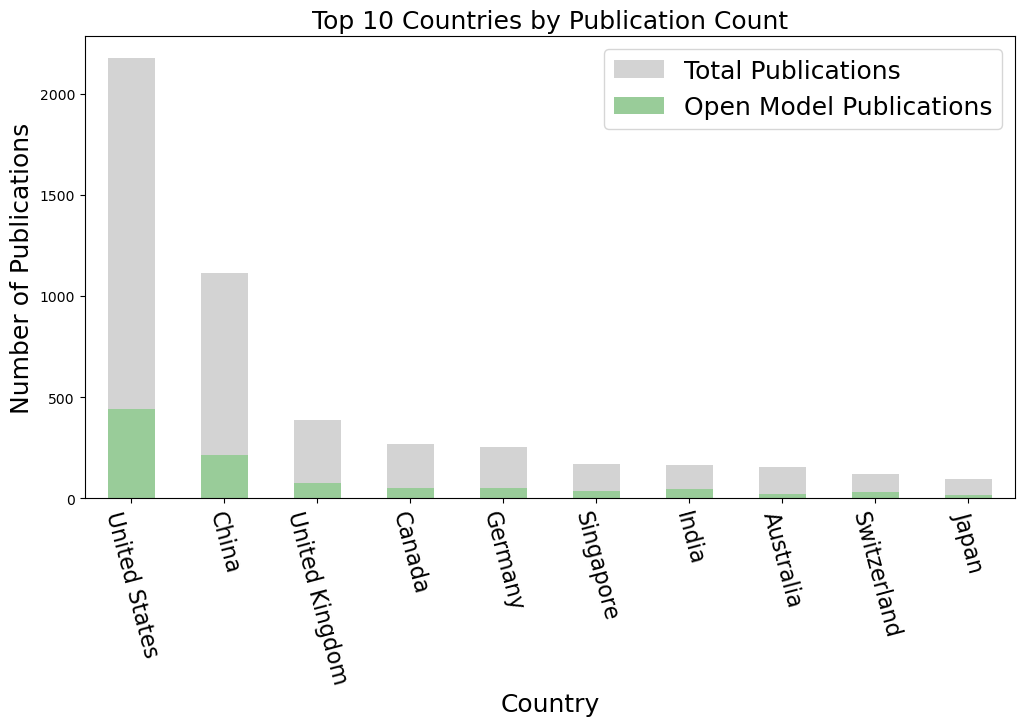

In [27]:
def process_country_data(df, country_type):
    # Create a DataFrame where each row represents a country
    countries_df = pd.DataFrame({
        'Country': [country for countries in df['Country'] for country in countries]
    })

    # Count the number of publications for each country
    country_counts = countries_df['Country'].value_counts()

    return country_counts

# Process the data
top_countries = process_country_data(llm_data_country, 'Country')
open_model_data = llm_data_country[llm_data_country['OpenModelNumber'] != 0]
open_model_counts = process_country_data(open_model_data, 'Country')

# Keep only the common indices
common_indices = open_model_counts.index.intersection(top_countries.index)
open_model_counts = open_model_counts.loc[common_indices]
top_countries = top_countries.loc[common_indices]

# Convert to DataFrame and reset index
top_countries_df = top_countries.reset_index().rename(columns={'index': 'Country', 'Country': 'Total Publications'})
open_model_counts_df = open_model_counts.reset_index().rename(columns={'index': 'Country', 'Country': 'Open Model Publications'})

# Merge the two dataframes
merged_df = pd.merge(top_countries_df, open_model_counts_df, on='Country', how='outer')

# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

# Sort by 'Total Publications'
merged_df.sort_values(by='Total Publications', ascending=False, inplace=True)

# Reset index after sorting
merged_df.reset_index(drop=True, inplace=True)

# Select the top 20 countries
top_20_countries = merged_df.head(10)

# Set the DPI
plt.figure(dpi=150)

# Now you can plot using top_20_countries
ax = top_20_countries.plot(x='Country', y='Total Publications', kind='bar', figsize=(12, 6), color='lightgray', label='Total Publications')
top_20_countries.plot(x='Country', y='Open Model Publications', kind='bar', color='#99CC99', ax=ax, label='Open Model Publications')

# Set the title and labels
plt.title('Top 10 Countries by Publication Count',fontsize=18)
plt.xlabel('Country',fontsize=18)
plt.ylabel('Number of Publications',fontsize=18)

# rotation
plt.xticks(rotation=-75)
plt.tick_params(axis='x', labelsize=16)
# Add a legend
plt.legend(fontsize=18)

# Show the plot
plt.show()

In [28]:
llm_data_institute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4417 entries, 0 to 5097
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_x                      4417 non-null   object        
 1   submitter                 4417 non-null   object        
 2   authors_x                 4417 non-null   object        
 3   title                     4417 non-null   object        
 4   comments                  2404 non-null   object        
 5   journal-ref               127 non-null    object        
 6   doi                       168 non-null    object        
 7   report-no                 8 non-null      object        
 8   categories                4417 non-null   object        
 9   license                   4417 non-null   object        
 10  abstract                  4417 non-null   object        
 11  versions                  4417 non-null   object        
 12  update_date         

C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\2900456847.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Month', y='All', data=df_bootstrap, ci=95, label='All', marker='o', markersize=3)
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\2900456847.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Month', y='ContainClose', data=df_bootstrap, ci=95, label='Close', marker='o', markersize=3)
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\2900456847.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Month', y='ContainOpen', data=df_bootstrap, ci=95, label='Open', marker='o', markersize=3)


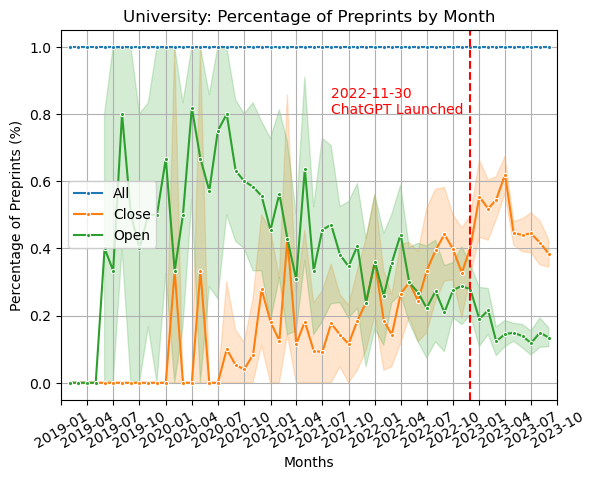

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# Filter the DataFrame to include only rows where 'university' is in 'Institute Type'
university_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x)]

# Initialize an empty list to store the data
data = []

# For each row in the DataFrame
for index, row in university_data.iterrows():
    # Create a dictionary to store the data for this row
    row_data = {'Month': row['month_year']}
    # Determine whether the row is in each category
    row_data['All'] = 1
    row_data['ContainModel'] = int(row['OpenModelNumber'] != 0)
    row_data['ContainClose'] = int(row['CloseModelNumber'] != 0)
    row_data['ContainOpen'] = int(row['OpenModelNumber'] != 0)
    # Add the data for this row to the list
    data.append(row_data)

# Convert the list to a DataFrame
df_bootstrap = pd.DataFrame(data)


# Convert 'Month' to datetime
df_bootstrap['Month'] = df_bootstrap['Month'].dt.to_timestamp()

# Now you can use seaborn's lineplot function to plot the data with a 95% confidence interval
sns.lineplot(x='Month', y='All', data=df_bootstrap, ci=95, label='All', marker='o', markersize=3)
sns.lineplot(x='Month', y='ContainClose', data=df_bootstrap, ci=95, label='Close', marker='o', markersize=3)
sns.lineplot(x='Month', y='ContainOpen', data=df_bootstrap, ci=95, label='Open', marker='o', markersize=3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # set x-ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format x-ticks as 'YYYY-MM'
ax.set_xlim([pd.Timestamp('2019-01'), pd.Timestamp('2023-10')])  # set x-axis limits

plt.xticks(rotation=30)
plt.xlabel('Months')
plt.ylabel('Percentage of Preprints (%)')
plt.title('University: Percentage of Preprints by Month')
plt.grid(True)

ax.axvline(pd.Timestamp('2022-11-30'), color='r', linestyle='--')  # add vertical line
ax.annotate('2022-11-30\nChatGPT Launched', xy=(pd.Timestamp('2022-11-30'), 0.8), xycoords='data', xytext=(-100,0), textcoords='offset points', color='r')  # add annotation

plt.show()

C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1308401858.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Month', y='All', data=df_bootstrap, ci=95, label='All', marker='o', markersize=3)
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1308401858.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Month', y='ContainClose', data=df_bootstrap, ci=95, label='Close', marker='o', markersize=3)
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1308401858.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Month', y='ContainOpen', data=df_bootstrap, ci=95, label='Open', marker='o', markersize=3)


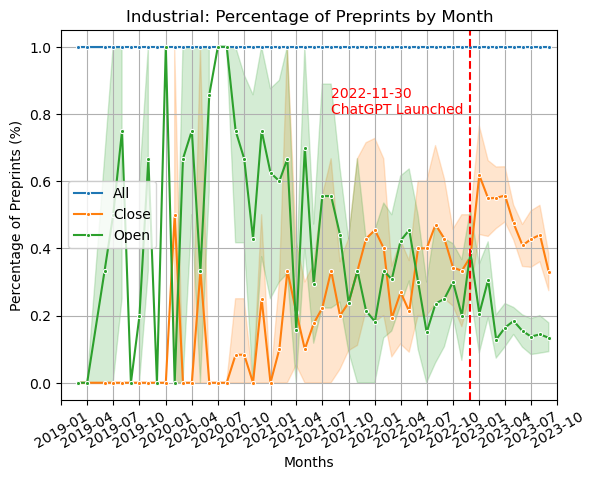

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# Filter the DataFrame to include only rows where 'university' is in 'Institute Type'
university_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'industrial' in x)]

# Initialize an empty list to store the data
data = []

# For each row in the DataFrame
for index, row in university_data.iterrows():
    # Create a dictionary to store the data for this row
    row_data = {'Month': row['month_year']}
    # Determine whether the row is in each category
    row_data['All'] = 1
    row_data['ContainModel'] = int(row['OpenModelNumber'] != 0)
    row_data['ContainClose'] = int(row['CloseModelNumber'] != 0)
    row_data['ContainOpen'] = int(row['OpenModelNumber'] != 0)
    # Add the data for this row to the list
    data.append(row_data)

# Convert the list to a DataFrame
df_bootstrap = pd.DataFrame(data)


# Convert 'Month' to datetime
df_bootstrap['Month'] = df_bootstrap['Month'].dt.to_timestamp()

# Now you can use seaborn's lineplot function to plot the data with a 95% confidence interval
sns.lineplot(x='Month', y='All', data=df_bootstrap, ci=95, label='All', marker='o', markersize=3)
sns.lineplot(x='Month', y='ContainClose', data=df_bootstrap, ci=95, label='Close', marker='o', markersize=3)
sns.lineplot(x='Month', y='ContainOpen', data=df_bootstrap, ci=95, label='Open', marker='o', markersize=3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # set x-ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format x-ticks as 'YYYY-MM'
ax.set_xlim([pd.Timestamp('2019-01'), pd.Timestamp('2023-10')])  # set x-axis limits

plt.xticks(rotation=30)
plt.xlabel('Months')
plt.ylabel('Percentage of Preprints (%)')
plt.title('Industrial: Percentage of Preprints by Month')
plt.grid(True)

ax.axvline(pd.Timestamp('2022-11-30'), color='r', linestyle='--')  # add vertical line
ax.annotate('2022-11-30\nChatGPT Launched', xy=(pd.Timestamp('2022-11-30'), 0.8), xycoords='data', xytext=(-100,0), textcoords='offset points', color='r')  # add annotation

plt.show()

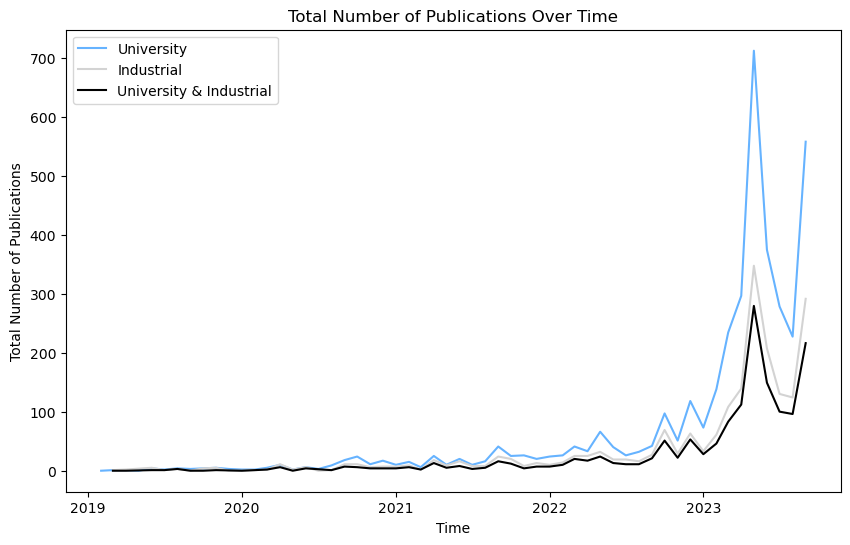

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where 'university' or 'industrial' is in 'Institute Type'
university_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x)]
industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'industrial' in x)]
university_industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x and 'industrial' in x)]

# Group by 'month_year' and count the number of publications for each month
university_counts = university_data.groupby('month_year').size()
industrial_counts = industrial_data.groupby('month_year').size()
university_industrial_counts = university_industrial_data.groupby('month_year').size()

# Convert 'month_year' to datetime
university_counts.index = university_counts.index.to_timestamp()
industrial_counts.index = industrial_counts.index.to_timestamp()
university_industrial_counts.index = university_industrial_counts.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(university_counts, label='University', color='#66B3FF')
plt.plot(industrial_counts, label='Industrial', color='lightgray')
plt.plot(university_industrial_counts, label='University & Industrial', color='black')

plt.xlabel('Time')
plt.ylabel('Total Number of Publications')
plt.title('Total Number of Publications Over Time')
plt.legend()

plt.show()

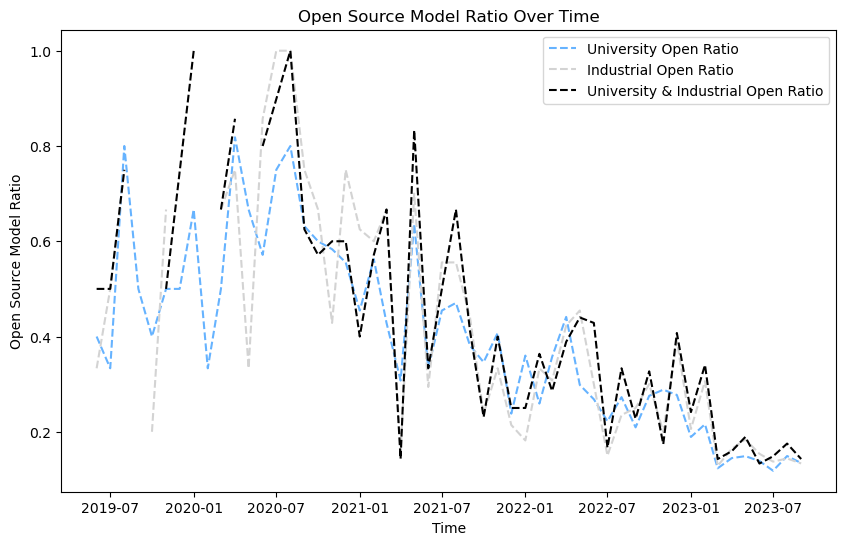

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where 'university' or 'industrial' is in 'Institute Type'
university_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x)]
industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'industrial' in x)]
university_industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x and 'industrial' in x)]

# Group by 'month_year' and count the number of publications for each month
university_counts = university_data.groupby('month_year').size()
industrial_counts = industrial_data.groupby('month_year').size()
university_industrial_counts = university_industrial_data.groupby('month_year').size()

# Group by 'month_year' and count the number of open source model papers for each month
university_open_counts = university_data[university_data['OpenModelNumber'] != 0].groupby('month_year').size()
industrial_open_counts = industrial_data[industrial_data['OpenModelNumber'] != 0].groupby('month_year').size()
university_industrial_open_counts = university_industrial_data[university_industrial_data['OpenModelNumber'] != 0].groupby('month_year').size()

# Calculate the ratio of open source model papers in total papers
university_ratio = university_open_counts / university_counts
industrial_ratio = industrial_open_counts / industrial_counts
university_industrial_ratio = university_industrial_open_counts / university_industrial_counts

# Convert 'month_year' to datetime
university_ratio.index = university_ratio.index.to_timestamp()
industrial_ratio.index = industrial_ratio.index.to_timestamp()
university_industrial_ratio.index = university_industrial_ratio.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(university_ratio, label='University Open Ratio', color='#66B3FF', linestyle='dashed')
plt.plot(industrial_ratio, label='Industrial Open Ratio', color='lightgray', linestyle='dashed')
plt.plot(university_industrial_ratio, label='University & Industrial Open Ratio', color='black', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Open Source Model Ratio')
plt.title('Open Source Model Ratio Over Time')
plt.legend()

plt.show()

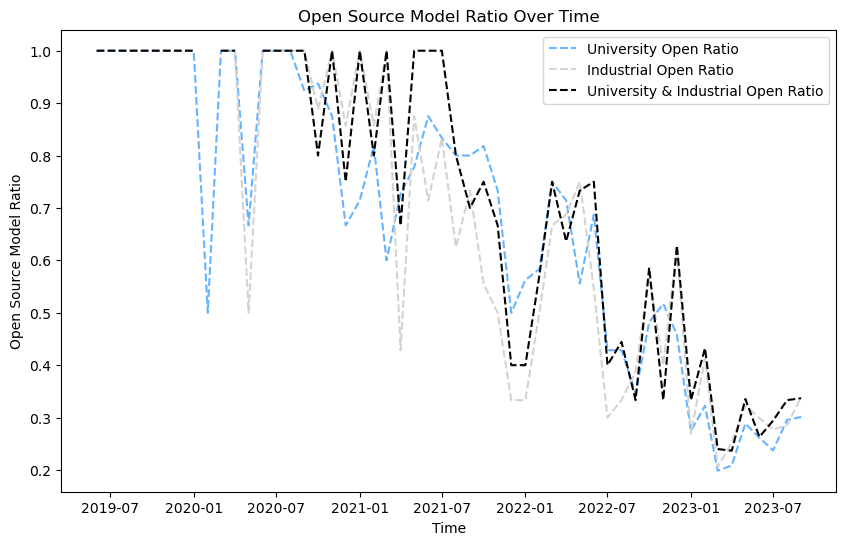

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where 'university' or 'industrial' is in 'Institute Type'
university_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x)]
industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'industrial' in x)]
university_industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in x and 'industrial' in x)]

# Group by 'month_year' and count the number of papers containing any models for each month
university_model_counts = university_data[university_data['modelNumber'] != 0].groupby('month_year').size()
industrial_model_counts = industrial_data[industrial_data['modelNumber'] != 0].groupby('month_year').size()
university_industrial_model_counts = university_industrial_data[university_industrial_data['modelNumber'] != 0].groupby('month_year').size()

# Group by 'month_year' and count the number of open source model papers for each month
university_open_counts = university_data[university_data['OpenModelNumber'] != 0].groupby('month_year').size()
industrial_open_counts = industrial_data[industrial_data['OpenModelNumber'] != 0].groupby('month_year').size()
university_industrial_open_counts = university_industrial_data[university_industrial_data['OpenModelNumber'] != 0].groupby('month_year').size()

# Calculate the ratio of open source model papers in total model papers
university_ratio = university_open_counts / university_model_counts
industrial_ratio = industrial_open_counts / industrial_model_counts
university_industrial_ratio = university_industrial_open_counts / university_industrial_model_counts

# Convert 'month_year' to datetime
university_ratio.index = university_ratio.index.to_timestamp()
industrial_ratio.index = industrial_ratio.index.to_timestamp()
university_industrial_ratio.index = university_industrial_ratio.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(university_ratio, label='University Open Ratio', color='#66B3FF', linestyle='dashed')
plt.plot(industrial_ratio, label='Industrial Open Ratio', color='lightgray', linestyle='dashed')
plt.plot(university_industrial_ratio, label='University & Industrial Open Ratio', color='black', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Open Source Model Ratio')
plt.title('Open Source Model Ratio Over Time')
plt.legend()

plt.show()

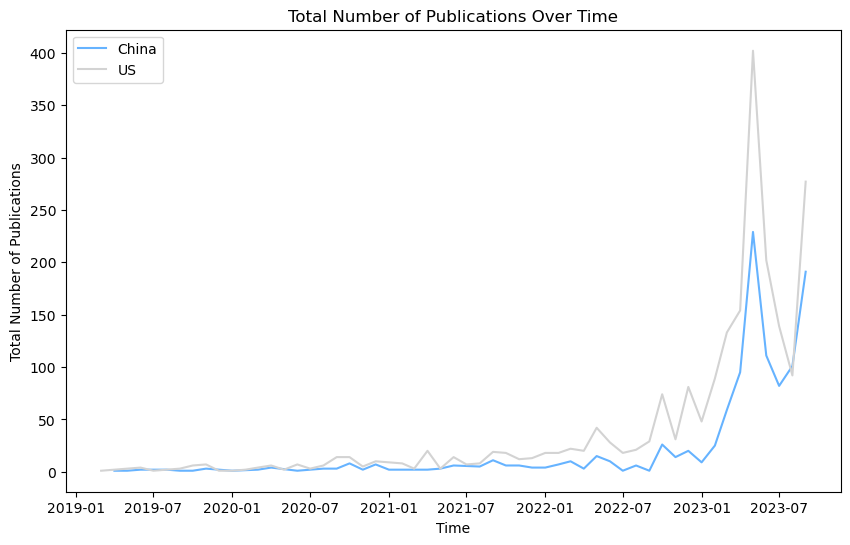

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where 'China' or 'US' is in 'Country'
china_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' in x)]
us_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'United States' in x)]

# Group by 'month_year' and count the number of publications for each month
china_counts = china_data.groupby('month_year').size()
us_counts = us_data.groupby('month_year').size()

# Convert 'month_year' to datetime
china_counts.index = china_counts.index.to_timestamp()
us_counts.index = us_counts.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(china_counts, label='China', color='#66B3FF')
plt.plot(us_counts, label='US', color='lightgray')

plt.xlabel('Time')
plt.ylabel('Total Number of Publications')
plt.title('Total Number of Publications Over Time')
plt.legend()

plt.show()

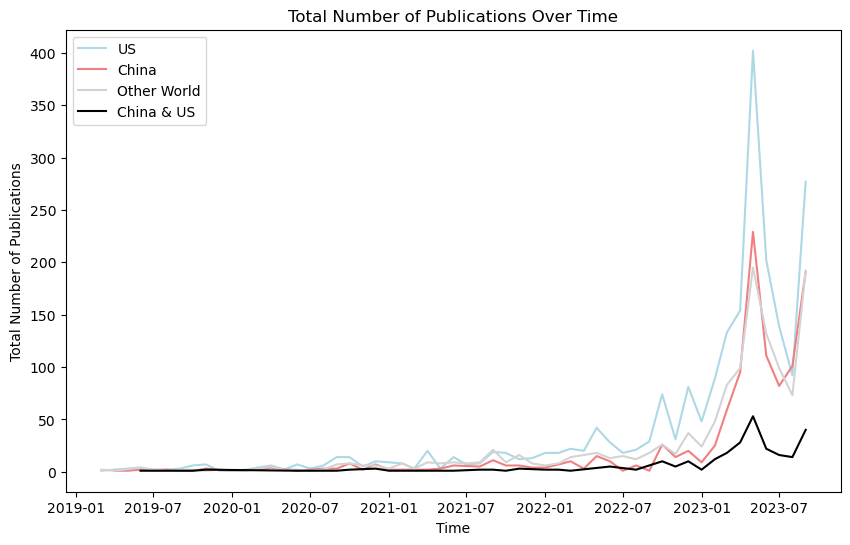

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where 'China' or 'United States' is in 'Country'
china_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' in x)]
us_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'United States' in x)]
china_us_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' in x and 'United States' in x)]
other_world_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' not in x and 'United States' not in x)]

# Group by 'month_year' and count the number of publications for each month
china_counts = china_data.groupby('month_year').size()
us_counts = us_data.groupby('month_year').size()
china_us_counts = china_us_data.groupby('month_year').size()
other_world_counts = other_world_data.groupby('month_year').size()

# Convert 'month_year' to datetime
china_counts.index = china_counts.index.to_timestamp()
us_counts.index = us_counts.index.to_timestamp()
china_us_counts.index = china_us_counts.index.to_timestamp()
other_world_counts.index = other_world_counts.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(us_counts, label='US', color='lightblue')
plt.plot(china_counts, label='China', color='lightcoral')
plt.plot(other_world_counts, label='Other World', color='lightgray')
plt.plot(china_us_counts, label='China & US', color='black')

plt.xlabel('Time')
plt.ylabel('Total Number of Publications')
plt.title('Total Number of Publications Over Time')
plt.legend()

plt.show()

In [36]:
china_counts

month_year
2019-04-01      1
2019-05-01      1
2019-06-01      2
2019-08-01      2
2019-09-01      1
2019-10-01      1
2019-11-01      3
2019-12-01      2
2020-01-01      1
2020-03-01      2
2020-04-01      4
2020-06-01      1
2020-08-01      3
2020-09-01      3
2020-10-01      8
2020-11-01      2
2020-12-01      7
2021-01-01      2
2021-02-01      2
2021-03-01      2
2021-04-01      2
2021-05-01      3
2021-06-01      6
2021-08-01      5
2021-09-01     11
2021-10-01      6
2021-11-01      6
2021-12-01      4
2022-01-01      4
2022-02-01      7
2022-03-01     10
2022-04-01      3
2022-05-01     15
2022-06-01     10
2022-07-01      1
2022-08-01      6
2022-09-01      1
2022-10-01     26
2022-11-01     14
2022-12-01     20
2023-01-01      9
2023-02-01     25
2023-03-01     59
2023-04-01     95
2023-05-01    229
2023-06-01    111
2023-07-01     82
2023-08-01    101
2023-09-01    191
dtype: int64

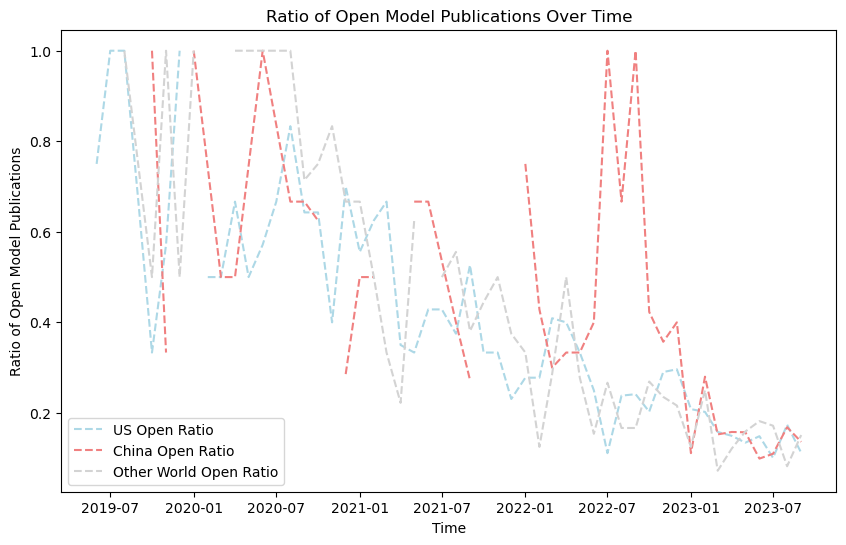

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where 'China' or 'United States' is in 'Country'
china_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' in x)]
us_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'United States' in x)]
china_us_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' in x and 'United States' in x)]
other_world_data = llm_data_country[llm_data_country['Country'].apply(lambda x: 'China' not in x and 'United States' not in x)]

# Group by 'month_year' and count the number of publications for each month
china_counts = china_data.groupby('month_year').size()
us_counts = us_data.groupby('month_year').size()
china_us_counts = china_us_data.groupby('month_year').size()
other_world_counts = other_world_data.groupby('month_year').size()

# Calculate the ratio of open source model papers in total model papers
china_ratio = china_data[china_data['OpenModelNumber'] != 0].groupby('month_year').size() / china_counts
us_ratio = us_data[us_data['OpenModelNumber'] != 0].groupby('month_year').size() / us_counts
china_us_ratio = china_us_data[china_us_data['OpenModelNumber'] != 0].groupby('month_year').size() / china_us_counts
other_world_ratio = other_world_data[other_world_data['OpenModelNumber'] != 0].groupby('month_year').size() / other_world_counts

# Convert 'month_year' to datetime
china_ratio.index = china_ratio.index.to_timestamp()
us_ratio.index = us_ratio.index.to_timestamp()
china_us_ratio.index = china_us_ratio.index.to_timestamp()
other_world_ratio.index = other_world_ratio.index.to_timestamp()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the ratio as dashed lines
plt.plot(us_ratio, label='US Open Ratio', color='lightblue', linestyle='dashed')
plt.plot(china_ratio, label='China Open Ratio', color='lightcoral', linestyle='dashed')
plt.plot(other_world_ratio, label='Other World Open Ratio', color='lightgray', linestyle='dashed')
# plt.plot(china_us_ratio, label='China & US Open Ratio', color='black', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Ratio of Open Model Publications')
plt.title('Ratio of Open Model Publications Over Time')
plt.legend()

plt.show()

In [38]:
llm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_x                      5098 non-null   object        
 1   submitter                 5098 non-null   object        
 2   authors_x                 5098 non-null   object        
 3   title                     5098 non-null   object        
 4   comments                  2732 non-null   object        
 5   journal-ref               143 non-null    object        
 6   doi                       176 non-null    object        
 7   report-no                 8 non-null      object        
 8   categories                5098 non-null   object        
 9   license                   5098 non-null   object        
 10  abstract                  5098 non-null   object        
 11  versions                  5098 non-null   object        
 12  update_date         

C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\3148612888.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_source_data['month_year'] = open_source_data['month_year'].dt.to_timestamp()
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\3148612888.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_source_data['month_year'] = closed_source_data['month_year'].dt.to_timestamp()
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\3148612888.py:15: FutureWarning: 

The `ci` parameter is deprec

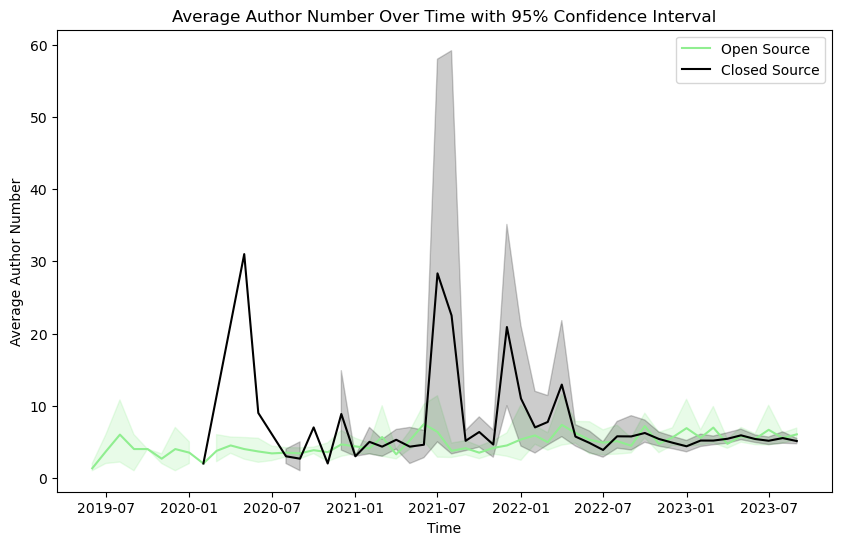

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Filter the DataFrame to include only rows where 'OpenModelNumber' != 0 or 'CloseModelNumber' != 0
open_source_data = llm_data[llm_data['OpenModelNumber'] != 0]
closed_source_data = llm_data[llm_data['CloseModelNumber'] != 0]

# Convert 'month_year' to datetime
open_source_data['month_year'] = open_source_data['month_year'].dt.to_timestamp()
closed_source_data['month_year'] = closed_source_data['month_year'].dt.to_timestamp()

# Plot the data with 95% confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='authorNumber', data=open_source_data, ci=95, color='lightgreen', label='Open Source')
sns.lineplot(x='month_year', y='authorNumber', data=closed_source_data, ci=95, color='black', label='Closed Source')

plt.xlabel('Time')
plt.ylabel('Average Author Number')
plt.title('Average Author Number Over Time with 95% Confidence Interval')
plt.legend()

plt.show()

C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1582455318.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  university_data['month_year'] = university_data['month_year'].dt.to_timestamp()
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1582455318.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industrial_data['month_year'] = industrial_data['month_year'].dt.to_timestamp()
C:\Users\jiawei\AppData\Local\Temp\ipykernel_23748\1582455318.py:13: SettingWithCopyWarning: 
A value is trying to be set 

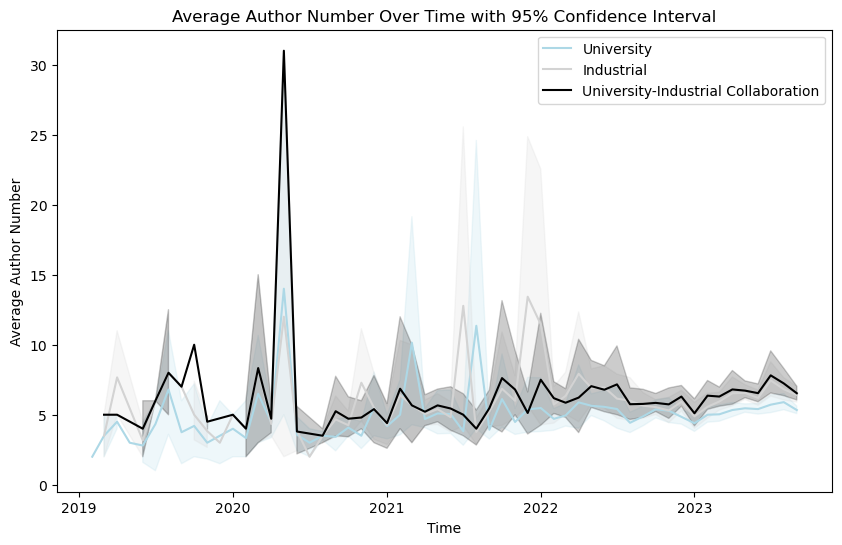

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Filter the DataFrame to include only rows where 'university', 'industrial' or both are in 'Institute Type'
university_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in [item.lower() for item in x])]
industrial_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'industrial' in [item.lower() for item in x])]
collaboration_data = llm_data_institute[llm_data_institute['Institute Type'].apply(lambda x: 'university' in [item.lower() for item in x] and 'industrial' in [item.lower() for item in x])]

# Convert 'month_year' to datetime
university_data['month_year'] = university_data['month_year'].dt.to_timestamp()
industrial_data['month_year'] = industrial_data['month_year'].dt.to_timestamp()
collaboration_data['month_year'] = collaboration_data['month_year'].dt.to_timestamp()

# Plot the data with 95% confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='authorNumber', data=university_data, ci=95, color='lightblue', label='University')
sns.lineplot(x='month_year', y='authorNumber', data=industrial_data, ci=95, color='lightgray', label='Industrial')
sns.lineplot(x='month_year', y='authorNumber', data=collaboration_data, ci=95, color='black', label='University-Industrial Collaboration')

plt.xlabel('Time')
plt.ylabel('Average Author Number')
plt.title('Average Author Number Over Time with 95% Confidence Interval')
plt.legend()

plt.show()

In [41]:
llm_data_institute.to_csv('llm_data_institute.csv', index=False)

In [42]:
llm_data_country.to_csv('llm_data_country.csv', index=False)